<h3 style="background-color: #daebff; border-color: #bad5f6; border-left: 5px solid #bad5f6; padding: 1.5em; color: #6f89a9">
Secondary Structure Classifier
</h3>

## Importing packages and setting up paths to training and testing files

In [83]:
training_labels_path = "Training_Labels.txt"
testing_labels_path = "Testing_Labels.txt"
expasy_aa_scales_path = "Expasy_AA_Scales.txt"
training_labels_path_short = "Training_Labels_short.txt"

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, plot_roc_curve
from sklearn import preprocessing

import urllib.request
from joblib import dump, load

## Feature Engineering

First we create a table of features by joining the table with labels and the table with Expasy AA scales on the corresponding amino acid. Then we calculate the following features:
- Feature blurring with a traingular window of 9 based on **average** value of the window 
- Feature blurring with a traingular window of 9 based on **maximum** value of the window 

These two types of features are useful because that is how the scale profile is usually computed. We cannot just rely on the value exactly at that position so we can consider the average of the window and also the maximum value of the window.

Here, we are using linear weight variation model which weighs the points that are closer to the center more.

I tried normalizing the data, but at the end, it did not change the AUC so it is commented out. I also experimented with the size of the window and 9 seems to work the best.

In [118]:
#Creates a triple of set X, set Y, and set X again but with UniProt column still included
#Features: blurring with a window of 9 for avg and max window values
def get_x_y(path, df = False):
    if df:
        train_df = path
    else:
        train_df = pd.read_csv(path, sep="\t")
    #reading in the file with labels and Expasy AA scales
    aa_df = pd.read_csv(expasy_aa_scales_path, sep="\t")
    aa_df = aa_df.rename(columns={"Amino Acid": "AA"})
    #Merging the df's on 'Amino Acid'
    train_df_m = pd.merge(train_df, aa_df, how='left', on=['AA'])
    #Keeping the Label for Y set
    train_y = pd.DataFrame(data=train_df_m["Label"], columns=["Label"])
    
    #Removing columns that include Position, Label, UniProt
    cols = list(train_df_m)[4:]
    #Feature blurring with a window of 9 based on average value of the window
    train_x_win_avg = train_df_m.groupby("UniProt")[cols].rolling(9, center=True, min_periods=1,win_type='triang').mean()
    train_x_win_avg = train_x_win_avg.add_suffix('_avg')
    #Feature blurring with a window of 9 based on maximum value of the window
    train_x_win_max = train_df_m.groupby("UniProt")[cols].rolling(9, center=True, min_periods=1,win_type='triang').max()
    train_x_win_max = train_x_win_max.add_suffix('_max')
    #Concatenating the two types of features
    train_x_win_avg=pd.concat([train_x_win_avg, train_x_win_max], axis=1)
    train_x = train_x_win_avg.reset_index().drop(["UniProt","level_1"], axis=1)
    uniprot_df = train_x_win_avg.reset_index().drop(["level_1"], axis=1)
#     min_max_scaler = preprocessing.MinMaxScaler()
#     train_x = pd.DataFrame(min_max_scaler.fit_transform(train_x), columns = train_x.columns)
#     uniprot_df = pd.DataFrame(min_max_scaler.fit_transform(uniprot_df), columns = train_x.columns[1:])
    return train_x,train_y,uniprot_df
# FUNCTION END

In [119]:
train_x_full,train_y_full,train_uniprot = get_x_y(training_labels_path)

## Data Exploration and Feature Selection
In this section, we look at a couple of box plots to see if there is visual difference between the labels. Since we derived two types of features from the same expasy scale (avg and max), we can graph them side by side.

In [ ]:
df_full = pd.concat([train_x_full, train_y_full], axis=1)

The plot below shows that this feature does not have the 0 and 1 label at the same level (at least for the figure on the left which shows the average of the window). Hence, we can make an assumption that *alpha_helix__Deleage_&_Roux* might be an important feature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f18adf45310>,
      dtype=object)

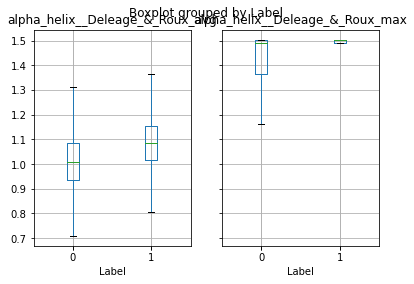

In [155]:
df_full.boxplot(column=['alpha_helix__Deleage_&_Roux_avg', 'alpha_helix__Deleage_&_Roux_max'], by='Label', sym='')

The boxplot below shows also shows a feature that does not have 0 and 1 label at the same level (for the avg window). So here we can also we can make an assumption that *alpha_helix__Levitt* might be an important feature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f18ae29db50>,
      dtype=object)

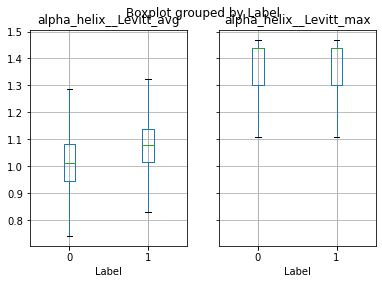

In [159]:
df_full.boxplot(column=['alpha_helix__Levitt_avg','alpha_helix__Levitt_max'], by='Label', sym='')

On the other hand, on the boxplot below the 0 and 1 labels are at almost the exact same level, so we can make an assumption that *HPLC__retention_pH_74* is not an important feature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f18adce2a00>,
      dtype=object)

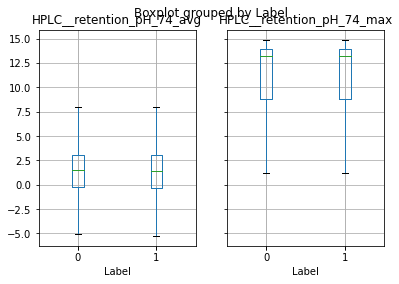

In [160]:
df_full.boxplot(column=['HPLC__retention_pH_74_avg', 'HPLC__retention_pH_74_max'], by='Label', sym='')

Instead of doing these boxplots 1 by 1 and deciding which feature is important we can do some feature selection which is discussed after the removal of highly correlated features.

### Assess correlation and remove highly correlated features
Below is a graph of all 114 features and their correlations. The dark colors show that some pairs of features are highly correlated.

We can find the ones where correlation is higher than 0.8 and remove these features. We are left with 42 features.

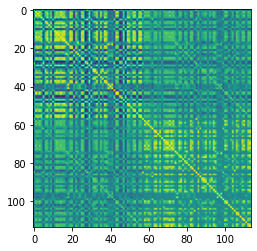

In [120]:
cor=np.corrcoef(train_x_full.values, rowvar=False)
plt.imshow(cor)

In [121]:
# Find column names with correlation higher than 0.8
corr = set()
for col in range(train_x_full.shape[1]):
    corr |= set([train_x_full.columns[col] for colx in range(col) if abs(cor[col,colx]) > 0.8])
noncorr = set(train_x_full.columns) - corr

In [122]:
def select_columns(df, select):
    return df.loc[:,select]
# FUNCTION END

In [123]:
# Remove features with correlation higher than 0.8
train_x_full = select_columns(train_x_full,noncorr)
train_x_full.shape

(378314, 42)

### Feature Selection
We can use Recursive Feature Elimination to do further feature selection. This method starts with the full model and then drops *n* features (in this case 3, not 1, due to time out computation issues) and refits it.

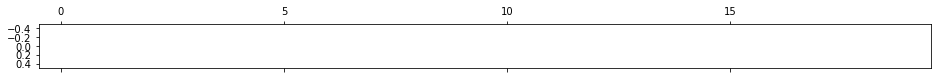

In [126]:
from sklearn.feature_selection import RFE
# Create RFE selector with RandomForestClassifier
select = RFE(RandomForestClassifier(n_estimators=100, max_features = 'sqrt', max_depth = 10), n_features_to_select=20, step=3)
train_y_ravel = train_y_full.values.ravel()
# Run the selector
select.fit(train_x_full[:97480], train_y_ravel[:97480])
# Visualize the selected features
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [127]:
# List selected features
selected = list(train_x_full.iloc[:,list(select.get_support())].columns)
selected 

['beta_turn__Deleage_&_Roux_max',
 '%_accessible_residues_avg',
 'AA_composition_max',
 'beta_sheet__Deleage_&_Roux_avg',
 'AA_composition_avg',
 'Refractivity_avg',
 'Bulkiness_avg',
 'beta_turn__Deleage_&_Roux_avg',
 'Hphob__Wolfenden_et_al_avg',
 'Coil__Deleage_&_Roux_avg',
 'Ratio_hetero_endside_avg',
 'Coil__Deleage_&_Roux_max',
 'Hphob__Black_max',
 'beta_sheet__Deleage_&_Roux_max',
 'Hphob__Welling_&_al_avg',
 'Average_flexibility_avg',
 'Recognition_factors_avg',
 'Relative_mutability_avg',
 'beta_turn__Chou_&_Fasman_max',
 'HPLC__retention_pH_74_avg']

In [131]:
# This is the same list as above but we don't need to wait for it to be recomputed every time the kernel dies :))
selected = ['beta_turn__Deleage_&_Roux_max','%_accessible_residues_avg','AA_composition_max','beta_sheet__Deleage_&_Roux_avg','AA_composition_avg','Refractivity_avg','Bulkiness_avg','beta_turn__Deleage_&_Roux_avg','Hphob__Wolfenden_et_al_avg','Coil__Deleage_&_Roux_avg','Ratio_hetero_endside_avg','Coil__Deleage_&_Roux_max','Hphob__Black_max','beta_sheet__Deleage_&_Roux_max','Hphob__Welling_&_al_avg','Average_flexibility_avg','Recognition_factors_avg','Relative_mutability_avg','beta_turn__Chou_&_Fasman_max','HPLC__retention_pH_74_avg']

In [132]:
# Select only the columns selected by RFE
train_x_full = select_columns(train_x_full,selected)
train_x_full.shape

(378314, 20)

### Split into train and validation sets
We can split the training set by 75:25 into training and validation sets. If we were to use train_test_split, then the observations would be randomly selected into train and validation sets which will break up the proteins into separate groups. We probably want to keep the groupped proteins together.

Hence, we can split the dataset around the 75:25 mark but round it to the closest group. Although, this removes some randomness, we can later use cross validation to see if the classifier does well.

In [133]:
split_idx = 264880
train_x = train_x_full[:split_idx] 
train_y = train_y_full[:split_idx]
val_x = train_x_full[split_idx:]
val_y = train_y_full[split_idx:]
train_y = train_y.values.ravel()
val_y = val_y.values.ravel()

## Random Forest
Now we can train the classifier.

To do that, we need to select optimal parameters (hyperparameter optimization). This can be done with GridSearchCV. 
For the ```max_features``` considered for each tree split we can try sqrt and log2 number of parameters. As for the ```max_depth``` of the tree, we can try 5, 10, and 20. We can also determine if we want to use resampling with ```bootsrap```.

I only ran this on about 1/3 of the training data (divided at the split between two proteins) because the server kept timing out when the entire dataset was included. We will use the full training dataset once the parameters are selected.

In [66]:
rf = RandomForestClassifier(n_estimators=200, random_state = 122)
parameters = {'max_features':['sqrt', 'log2'],
              'max_depth':[5,10,20],
              'bootstrap': [True, False]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(train_x[:97480], train_y[:97480])

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2']})

In [67]:
clf_grid.score(val_x, val_y)

0.8010208579438264

In [68]:
clf_grid.best_params_

{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt'}

The parameters selected by the grid are ```boostrap = True, max_features = sqrt```, and  ```max_depth = 10```. So that is what we will use to train the classifier on the full training dataset.

In [134]:
clf = RandomForestClassifier(n_estimators=200, max_features = 'sqrt', max_depth = 10, 
                             bootstrap = True, random_state = 122, n_jobs=-1)
clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=200,
                       n_jobs=-1, random_state=122)

In [135]:
# Accuracy based on the validation set
clf.score(val_x, val_y)

0.8105506285593385

In [69]:
# Top 15 most important features
sorted(list(zip(train_x.columns.values,clf.feature_importances_)), key=lambda x: -x[1])

[('Coil__Deleage_&_Roux_avg', 0.28840786254488576),
 ('Coil__Deleage_&_Roux_max', 0.10691220299871185),
 ('beta_turn__Deleage_&_Roux_avg', 0.07274793138132787),
 ('Recognition_factors_avg', 0.06839200820997152),
 ('Ratio_hetero_endside_avg', 0.05325619839137729),
 ('beta_sheet__Deleage_&_Roux_avg', 0.043721388166467555),
 ('Average_flexibility_avg', 0.036994599898003466),
 ('AA_composition_max', 0.03593951418198285),
 ('beta_turn__Deleage_&_Roux_max', 0.03313758103559683),
 ('beta_turn__Chou_&_Fasman_max', 0.030635425579436586),
 ('Refractivity_avg', 0.029796666146402653),
 ('beta_sheet__Deleage_&_Roux_max', 0.025216493007955264),
 ('HPLC__retention_pH_74_avg', 0.02508050811100175),
 ('Hphob__Wolfenden_et_al_avg', 0.023950398806660028),
 ('Bulkiness_avg', 0.023735402908576727),
 ('AA_composition_avg', 0.022479976256720904),
 ('Hphob__Black_max', 0.02174006149399361),
 ('Hphob__Welling_&_al_avg', 0.021221957468132144),
 ('Relative_mutability_avg', 0.019353721315139898),
 ('%_accessible_

#### Recall
Below is the output for the classification table.

Specificity is 99% and sensitivity is 6% which means the model is very good at predicting true negatives (0 label when it's actually 0) and is terrible at predicting true positives (1 label when it's actually 1). This can probably be explained by a very zero-inflated dataset.

In [138]:
pred_y_label = clf.predict(val_x)
print(classification_report(val_y, pred_y_label))

              precision    recall  f1-score   support

           0       0.82      0.99      0.89     91880
           1       0.51      0.06      0.10     21554

    accuracy                           0.81    113434
   macro avg       0.67      0.52      0.50    113434
weighted avg       0.76      0.81      0.74    113434



### ROC AUC
The AUC score is 0.714.

In [136]:
pred_y = clf.predict_proba(val_x)[:, 1]
auc = roc_auc_score(val_y, pred_y)
auc

0.7136108783725674

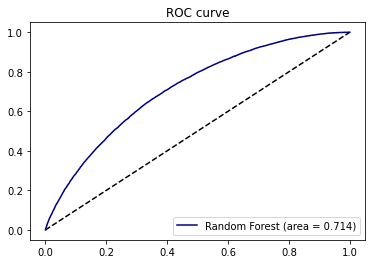

In [137]:
fpr, tpr, _ = roc_curve(val_y, pred_y)

plt.figure()
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='navy', label='Random Forest (area = %0.3f)' % auc) 
plt.legend(loc='lower right')
plt.show()

#### Cross-Validation
We can also assess the model's fit by used K-fold cross-validation. In this case, we can use 5 folds.

Since each observation in the train set is dependent on which protein it relates to, we cannot just randomly divide the set because it will split some observations for a protein into two parts. 

The function below creates the indicies for the folds by grouping the dataset by UniProt and then taking an equal amount of groups into each fold.

In [139]:
#CV method
def yield_cv_fold_indicies(train_uniprot,folds = 5):
    cols = list(train_uniprot)[1:]
    # Group by UniProt
    grouped = train_uniprot.groupby("UniProt")
    # Calculate the number of groups per fold
    per_fold = int(len(grouped.size())/folds)
    prev_idx = 0
    for i, g_idx in enumerate(range(per_fold,len(grouped),per_fold)):
        if i == folds-1:
            return
        # Yield an array of indicies to be included in the fold (they are just incremented sequentially)
        idx = grouped.size()[:g_idx].sum()
        idx_arr = np.arange(prev_idx, idx)
        prev_idx = idx
        yield idx_arr,idx_arr
# FUNCTION END        

In [140]:
train_y_array = train_y_full.to_numpy().ravel()
train_x_array = train_x_full.to_numpy()

In [141]:
# Get fold indicies
cv = yield_cv_fold_indicies(train_uniprot)
# Perform cross validation
cv_score_arr = cross_val_score(clf, train_x_array, train_y_array, cv=cv)
# Get the mean accuracy rate from the 5 folds.
np.mean(cv_score_arr)

0.7939555741852499

**The accuracy is around 79.4%.**

### Assessing accuracy using the testing set
Now we can finally see how well the classifier does on the test set.

In [142]:
# Read in the test dataset and create the features 
test_x,test_y,test_uniprot = get_x_y(testing_labels_path)

In [143]:
# Select only the important features (as derived in the feature selection section)
test_x = select_columns(test_x,selected)

In [144]:
# Predict the labels
pred_y = clf.predict_proba(test_x)[:, 1]
# Get AUC
auc = roc_auc_score(test_y, pred_y)
auc

0.7167357597300691

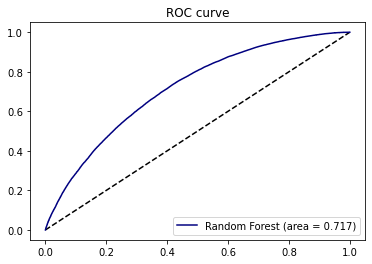

In [145]:
# Draw ROC
fpr, tpr, _ = roc_curve(test_y, pred_y)

plt.figure()
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='navy', label='Random Forest (area = %0.3f)' % auc) 
plt.legend(loc='lower right')
plt.show()

**The area under the curve is 0.717 based on the test set.**

In [146]:
# Saving precalculated features
df_features=pd.concat([train_uniprot,
                     test_uniprot], axis=0)
df_features.to_csv('features.csv', index=False)

---

## UniProt Prediction
The classifier can be used on:
- UniProt that are already in the dataset. The features *are not* recomputed but are retrieved from a table of saved features.
- UniProt that are *not* in the dataset. For these we access uniprot.org to retrieve *only* the AA sequence (not the labels). If the given ID is invalid, then the function throws an exception.

The classifier includes 3 functions ```get_features, predict_uniprot,``` and ```predict_uniprot_proba```.

In [147]:
# Get the amino acid sequence for the given UniProt
# Throws an exception if the ID is invalid
# Ex: retrieve_aa_seq('P30615') returns 'MSQLEHN.....RLIYLP'
def retrieve_aa_seq(UniProt):
    url='https://www.uniprot.org/uniprot/' + UniProt + '.fasta'
    with urllib.request.urlopen(url) as response:
        content = response.read().decode("utf-8")
    content = ''.join(content.split('\n')[1:])
    return content
# FUNCTION END

# Creates a df with UniProt, Position, AA, Label
# The label is a dummy label (-1) and is discarded
def create_x_df(aa_seq, uniprot):
    len_prot = len(aa_seq)
    position = list(range(1,len_prot+1))
    aa = list(aa_seq)
    uniprot_lst =  [uniprot for _ in range(len_prot)] 
    label =  [-1 for _ in range(len_prot)] 
    data = {'UniProt':uniprot_lst, 'Position':position, 'AA':aa, 'Label':label}
    return pd.DataFrame(data)
# FUNCTION END

In [148]:
# Create Function for obtianing features
def get_features(UniProt):
    # Get features saved from both the test and train sets
    features = pd.read_csv("features.csv")
    # If UniProt is in the original dataset, find the UniProt group and return the features
    if UniProt in features.UniProt.values:
        features_x = features.groupby("UniProt").get_group(UniProt).iloc[:,1:] #.drop(["level_1"], axis=1)
        return  select_columns(features_x,selected)
        #return features_x
    
    # If UniProt is not in the dataset, retrieve the AA sequence from uniprot.org
    aa_seq = retrieve_aa_seq(UniProt)
    # Calculate the features 
    features,_,_ = get_x_y(create_x_df(aa_seq, UniProt), df=True)
    return select_columns(features,selected)  
    #return features_x
# FUNCTION END

# Create Function for obtaining predicitons
def predict_uniprot(self, UniProt):
    # Get features
    X = self.get_features(UniProt)

    # Make / return predictions
    return self.predict(X)
# FUNCTION END

def predict_uniprot_proba(self, UniProt):
    # Get features
    X = self.get_features(UniProt)

    # Make / return prediction probabilities
    return self.predict_proba(X)
# FUNCTION END

In [149]:
clf.get_features = get_features
clf.predict_uniprot = predict_uniprot
clf.predict_uniprot_proba = predict_uniprot_proba

#### Usage of the classifier
Below are examples of how to use the classifier
- Predict labels for P30615 which is already in the dataset
- Predict probabilities for P30615 which is already in the dataset
- Predict lables for Q10469 which is not in the original dataset

In [150]:
clf.predict_uniprot(clf, "P30615")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [151]:
clf.predict_uniprot_proba(clf, "P30615")

array([[0.61702011, 0.38297989],
       [0.61721862, 0.38278138],
       [0.68645873, 0.31354127],
       [0.65210276, 0.34789724],
       [0.76328241, 0.23671759],
       [0.77078309, 0.22921691],
       [0.77078309, 0.22921691],
       [0.75025545, 0.24974455],
       [0.75260372, 0.24739628],
       [0.75260372, 0.24739628],
       [0.8450463 , 0.1549537 ],
       [0.83131909, 0.16868091],
       [0.81653006, 0.18346994],
       [0.74993883, 0.25006117],
       [0.77192106, 0.22807894],
       [0.69963254, 0.30036746],
       [0.65144763, 0.34855237],
       [0.77233728, 0.22766272],
       [0.81001835, 0.18998165],
       [0.59049716, 0.40950284],
       [0.59049716, 0.40950284],
       [0.66251386, 0.33748614],
       [0.73920625, 0.26079375],
       [0.72542062, 0.27457938],
       [0.82904747, 0.17095253],
       [0.91410088, 0.08589912],
       [0.91223194, 0.08776806],
       [0.92727823, 0.07272177],
       [0.93220671, 0.06779329],
       [0.95559612, 0.04440388],
       [0.

In [152]:
clf.predict_uniprot(clf, "Q10469")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

---

## K Nearest Neighbors
Besides the Random Forest classifier, we can try other methods. Below, we perform hyperparameter optimization with Grid Search CV with 45, 60, and 80 nearest neighbors to consider. 
We get that 60 nearest neighbors gets the best result.

In [46]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[45,60,80]}
# Create the CV search grid
knn_grid = GridSearchCV(knn, parameters, n_jobs=-1)
# Fit models with different parameters. Using 1/3 of the dataset for timeout reasons.
knn_grid.fit(train_x[:97480], train_y[:97480])

0.8008709910608812

In [47]:
knn_grid.best_params_

{'n_neighbors': 60}

In [153]:
# Using 60 neighbors as chosen by the grid search
knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(train_x, train_y)
# Accuracy using the validation set
knn.score(val_x, val_y)

0.8073946083184935

The AUC using the validation set for KNN classifier is 0.68.

In [154]:
knn_pred = knn.predict_proba(val_x)[:, 1]
knn_auc = roc_auc_score(val_y, knn_pred)
knn_auc

0.6796386988604095

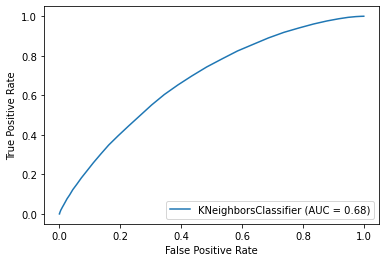

In [155]:
svc_disp = plot_roc_curve(knn, val_x, val_y)
plt.show()

In [156]:
# Set the functions for individual predictions
knn.get_features = get_features
knn.predict_uniprot = predict_uniprot
knn.predict_uniprot_proba = predict_uniprot_proba

In [157]:
# Get fold indicies
cv = yield_cv_fold_indicies(train_uniprot)
# Perform cross validation
cv_score_arr = cross_val_score(knn, train_x_array, train_y_array, cv=cv)
# Get the mean accuracy rate from the 5 folds.
np.mean(cv_score_arr)

0.777963002391619

The accuracy using 5-fold CV is 77.8%.

## AdaBoost Classifier
We can also try an AdaBoost classifier with Decision Tree. 
The resulting AUC is 0.71.

In [158]:
# Create AdaBoost instance
adab = AdaBoostClassifier(n_estimators=100)
# Fit the model
adab.fit(train_x, train_y)
# Accuracy based on the validation set
adab.score(val_x, val_y)

0.8067246151947388

The AUC using the validation set for AdaBoost classifier is 0.713.

In [159]:
adab_pred = adab.predict_proba(val_x)[:, 1]
adab_auc = roc_auc_score(val_y, adab_pred)
adab_auc

0.712757803354982

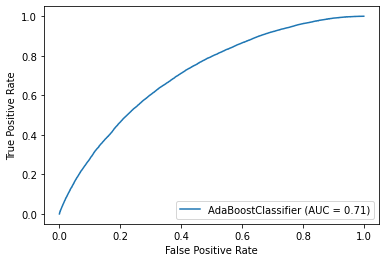

In [160]:
svc_disp = plot_roc_curve(adab, val_x, val_y)
plt.show()

In [161]:
# Set the functions for individual predictions
adab.get_features = get_features
adab.predict_uniprot = predict_uniprot
adab.predict_uniprot_proba = predict_uniprot_proba

In [162]:
# Get fold indicies
cv = yield_cv_fold_indicies(train_uniprot)
# Perform cross validation
cv_score_arr = cross_val_score(adab, train_x_array, train_y_array, cv=cv)
# Get the mean accuracy rate from the 5 folds.
np.mean(cv_score_arr)

0.7784151441796876

The accuracy using 5-fold CV is 78%.

### Graphing ROC based on testing set using three models

In [163]:
# Get AUC
rf_pred = clf.predict_proba(test_x)[:, 1]
rf_auc = roc_auc_score(test_y, rf_pred)
knn_pred = knn.predict_proba(test_x)[:, 1]
knn_auc = roc_auc_score(test_y, knn_pred)
adab_pred = adab.predict_proba(test_x)[:, 1]
adab_auc = roc_auc_score(test_y, adab.predict_proba(test_x)[:, 1])

0.7167357597300691

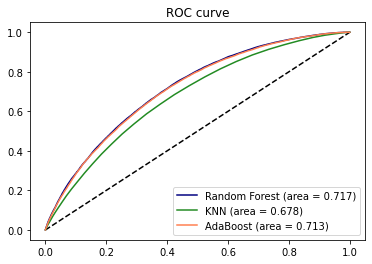

In [164]:
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_pred)
knn_fpr, knn_tpr, _ = roc_curve(test_y, knn_pred)
adab_fpr, adab_tpr, _ = roc_curve(test_y, adab_pred)

plt.figure()
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, color='navy', label='Random Forest (area = %0.3f)' % rf_auc) 
plt.plot(knn_fpr, knn_tpr, color='forestgreen', label='KNN (area = %0.3f)' % knn_auc) 
plt.plot(adab_fpr, adab_tpr, color='coral', label='AdaBoost (area = %0.3f)' % adab_auc) 
plt.legend(loc='lower right')
plt.show()

### Exporting the models
Now we can export the three models (Random Forest, AdaBoost, and KNN) to use them on the website.

In [165]:
dump(clf, 'final_clf.joblib') 

['final_clf.joblib']

In [166]:
dump(knn, 'knn_clf.joblib') 

['knn_clf.joblib']

In [167]:
dump(adab, 'adab_clf.joblib') 

['adab_clf.joblib']

**To use these in another file, please copy over model.py and make sure that the path to features.csv is correct. Then import ```from model import get_features, predict_uniprot, predict_uniprot_proba``` along with the classifier.**

In [168]:
clf2 = load('final_clf.joblib') 
clf2.predict_uniprot(clf2, 'P30615')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

See the website here:
http://bscb-teaching.cb.bscb.cornell.edu/~kvz3/index.html